# 基于有限差分法的二维定态薛定谔方程可视化分析

### 前言：基于有限差分法的一维定态薛定谔方程分析
一维定态薛定谔方程：
$$ \frac{-\hbar^2}{2m}\frac{\partial^2\psi}{\partial x^2} +V\psi=E\psi$$
有限差分法(FDM)中用于近似二阶偏导数的三点模板
对 $\psi_{i+1}$,$\psi_{i-1}$ 进行泰勒展开
在有限差分方法中，我们常常使用泰勒展开的前几项来近似函数的导数
$$ \psi(x_{i+1})=\psi(x_i)+\psi'(x_i) (\Delta x) + \frac12\psi''(x_i)(\Delta x)^2 +O\left((\Delta x)^3\right) $$
$$ \psi(x_{i-1})=\psi(x_i)-\psi'(x_i) (\Delta x) + \frac12\psi''(x_i)(\Delta x)^2 -O\left((\Delta x)^3\right) $$
上面两式相加
$$ \psi(x_{i+1})-2\psi(x_i)+\psi(x_{i-1})=\psi''(x_i)(\Delta x)^2+O\left((\Delta x)^4\right) $$
$$ \psi''(x_i)=\frac{\psi(x_{i+1})-2\psi(x_i)+\psi(x_{i-1})}{(\Delta x)^2}-\frac{O\left((\Delta x)^4\right)}{(\Delta x)^2}=\frac{\psi(x_{i+1})-2\psi(x_i)+\psi(x_{i-1})}{(\Delta x)^2}-O\left((\Delta x)^2\right) $$
$$ \psi''(x_i)\approx \frac{\psi(x_{i+1})-2\psi(x_i)+\psi(x_{i-1})}{(\Delta x)^2} $$
$\Delta x$越小，数据越精准
所以有:
$$ \frac{\partial^2 \psi_{i}}{\partial x^2}=\frac{\psi_{i+1}-2\psi_i+\psi_{i-1}}{(\Delta x)^2} $$ 
将上式代入薛定谔方程
$$ -\frac{\hbar^2}{2m}\frac{\psi_{i+1}-2\psi_i+\psi_{i-1}}{(\Delta x)^2}+V_i\psi_i=E\psi_i $$
$$ -\frac{1}{2(\Delta x)^2}\left(\psi_{i-1} +\left(-2-\left(\frac{2m}{\hbar^2}(\Delta x)^2V_i\right)\right)\psi_i+\psi_{i+1}\right)=\frac{m}{\hbar^2}E\psi_i$$
$$ -\frac{1}{2(\Delta x)^2}\psi_{i-1}+\frac{1}{(\Delta x)^2}\psi_i -\frac{1}{2(\Delta x)^2}\psi_{i+1}+\frac{m}{\hbar^2} V_i\psi_i =\frac{m}{\hbar^2}E\psi_i $$
为数值分析更为方便精确，这里我们令$\hbar=1$,即：
$$-\frac{1}{2(\Delta x)^2}\psi_{i-1}+\frac{1}{(\Delta x)^2}\psi_i  -\frac{1}{2(\Delta x)^2}\psi_{i+1}+mV_i\psi_i=mE\psi_i$$
写成矩阵形式，此处使用无限深方势阱的边界条件$\psi_0=0,\psi_N=0$:
$$
\begin{bmatrix}
\frac{1}{(\Delta x)^2}+mV_1 & -\frac{1}{2(\Delta x)^2} & 0 & \cdots & 0 \\
-\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2}+mV_2&-\frac{1}{2(\Delta x)^2} &\cdots & 0\\
0 &-\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2}+mV_3&\cdots &0\\
\vdots & \vdots & \vdots & \ddots&\vdots\\
0&\cdots&0 &-\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2}+mV_{N-1}\\
\end{bmatrix}
\begin{bmatrix}
\psi_1\\
\psi_2\\
\cdots\\
\psi_{N-1}\\
\end{bmatrix}
=mE
\begin{bmatrix}
\psi_1\\
\psi_2\\
\cdots\\
\psi_{N-1}\\
\end{bmatrix}
$$
可知$$\hat H=\hat T +\hat V$$
所以动能算符
$$\hat T=
-\frac{1}{2(\Delta x)^2}
\begin{bmatrix}
-2&1&0&\cdots&0\\
1&-2&1&\cdots&0\\
0&1&-2&\cdots&0\\
\vdots & \vdots & \vdots & \ddots&\vdots\\
0&\cdots&1&-2&1\\
0&\cdots&\cdots&1&-2\\
\end{bmatrix}
$$
$$ \hat V=m
\begin {bmatrix}
V_1&0&0&\cdots&0\\
0&V_2&0&\cdots&0\\
0&0&V_3&\cdots&0\\
\vdots&\vdots&\vdots&\ddots&\vdots\\
0&\cdots&\cdots&0&V_{N-1}\\
\end{bmatrix}
$$

In [32]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
from scipy import sparse
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
print(torch.version.cuda)
print(torch.cuda.is_available())

None
False


二维平面下的波函数矩阵为：
$$
\begin{bmatrix}
\psi_{11} & \psi_{12}& \cdots &\psi_{1N} \\
\psi_{21} & \psi_{22}& \cdots &\psi_{2N} \\
\vdots & \vdots & \ddots & \vdots \\
\psi_{N1} & \psi_{N2} & \cdots & \psi_{NN}\\
\end{bmatrix}
$$

In [33]:
#在x,y轴0-1范围内建立起均匀网格
N=400
X,Y=np.mgrid[0:1:1j*N,0:1:1j*N]


令$\hbar=1$,二维下的哈密顿算符可表示为：
$$\hat H = -\frac{1}{2m}\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\right)+\hat V(x,y)$$

使用克罗内克和离散化拉普拉斯算子,即：
$$\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}=D_{xx}\oplus D_{yy}$$

其中：
$$D_{xx}\oplus D_{yy}=D_{xx}\otimes I + I \otimes D_{yy}$$

令$D_{xx}=\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{bmatrix},
D_{yy}=\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\
\end{bmatrix}$ <br>


则 
$$ D_{xx} \oplus D_{yy}=\begin{bmatrix}
a_{11}+b_{11} & b_{12} & a_{12} & 0 \\
b_{21} & a_{11}+b_{22} & 0 & a_{12} \\
a_{21} & 0 & a_{22}+b_{11} & b_{12} \\
0 & a_{21} & b_{21} & a_{22}+b_{22} \\
\end{bmatrix}
$$

使用克罗内克和离散化拉普拉斯算子，并作用在波函数$ \psi $上可得：
$$\left[-\frac{1}{2}(D \oplus D) + m(\Delta x)^2VI \right] \psi = \left(m(\Delta x)^2  E\right) \psi$$


由于此处D是$ N^2 \times N^2 $矩阵，此处使用reshape()把波函数矩阵变为如下 $ 1 \times N^2 $
$$ 
\begin{bmatrix}
\psi_{11} \\
\psi_{12} \\
\psi_{13} \\
\vdots \\
\psi_{NN} \\
\end{bmatrix}
$$

此时的势能函数
$$ V=\begin{bmatrix}
V_{11} & 0 & \cdots & 0 \\
0 & V_{12} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & V_{NN}
\end{bmatrix}
 $$

In [34]:
def gaussian(x,y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V=gaussian(X,Y)

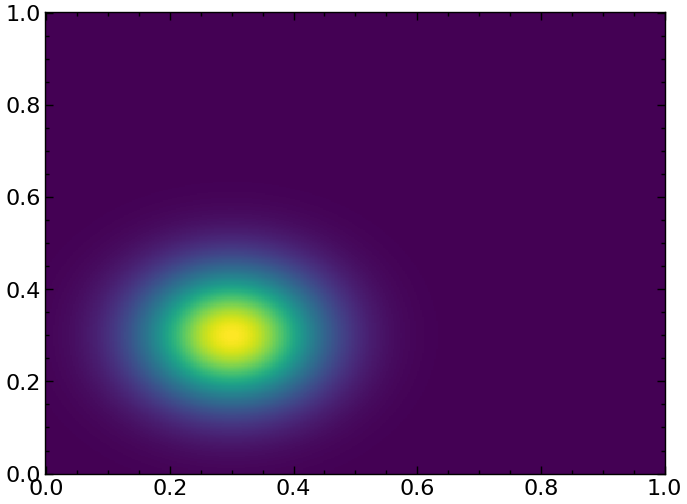

In [35]:
plt.pcolormesh(X,Y,V,cmap='viridis')

此处让 $\hat T=-\frac{1}{2}D\oplus D$, $U=m(\Delta x)^2V$

In [36]:
diag=np.ones([N])
diags=np.array([diag,-2*diag,diag])
#创建稀疏矩阵
D=sparse.spdiags(diags,[-1,0,1],N,N)
T=-1/2*sparse.kronsum(D,D)
U=sparse.diags(V.reshape(N**2),(0))
H=T+U

In [37]:
#gpu加速
H=H.tocoo()
H=torch.sparse_coo_tensor(indices=torch.tensor([H.row,H.col]),values=torch.tensor(H.data),size=H.shape).to(device)

In [38]:
#求解特征值,特征向量,找10个最小的特征值
eigenvalues,eigenvectors=lobpcg(H,k=10,largest=False)

In [20]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

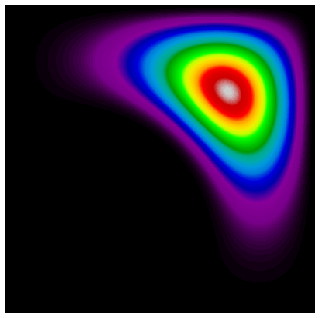

In [11]:
plt.figure(figsize=(4,4))
plt.pcolormesh(X,Y,get_e(0)**2,cmap='nipy_spectral')
plt.axis('off')
plt.show()

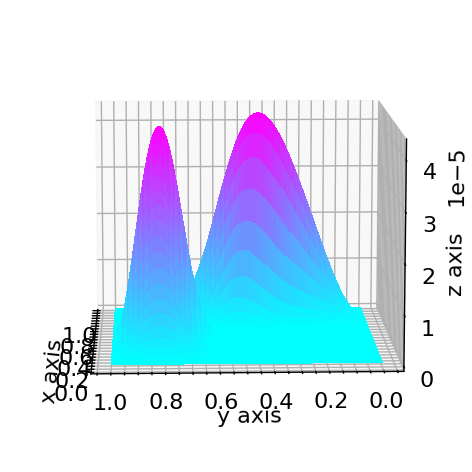

In [12]:


my_cmap = plt.get_cmap('cool')

def init():
    # Your code to set up the initial state of the figure, e.g.:
    # Plot the initial frame of the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=my_cmap, linewidth=0, antialiased=False)
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    return (surf,)  # Return a tuple containing the artists

def animate(i):
    # Your code to update the state of the figure for new frame `i`
    # Rotate the view.
    ax.view_init(elev=10, azim=2*i)
    return fig

# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create X, Y, Z data for the initial plot here
# X, Y, Z = ...

# Create initial plot
Z=get_e(1)**2
# surf = ax.plot_surface(X, Y,Z, cmap=my_cmap, linewidth=0, antialiased=False)
init()  # Initialize the figure with your init function

# Create the animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=90, interval=50)

# Save the animation
ani.save('rotate_azimuth_angle_3d_surf.gif', writer='pillow', fps=20)
